This example concerns the Paper "Perfect Quantum State Transfer in a Superconducting Qubit Chain with
Parametrically Tunable Couplings" from 2015

In [ ]:
# Add the feedback-grape git submodule to the path
import sys, os
sys.path.append(os.path.abspath("./../feedback-grape"))
sys.path.append(os.path.abspath("./../"))

from feedback_grape.utils.operators import (
    sigmap,
    sigmam,
    sigmax,
    sigmay,
    sigmaz,
)
from feedback_grape.utils.states import basis
from feedback_grape.utils.tensor import tensor
from feedback_grape.fgrape import optimize_pulse, Gate, Decay
import jax
from jax import numpy as jnp
from library.utils.qubit_chain_1D import embed
from tqdm import tqdm
from jax.scipy.linalg import expm
from matplotlib import pyplot as plt

# Training parameters
N_samples = 10 # Number of random initializations to test
N_training_iterations = 1000 # Number of training iterations
learning_rate = 0.02 # Learning rate
alphas = jnp.linspace(-0.95, 1, 5, endpoint=False) # Coefficients for initial superposition state

# System parameters
n = 9 # Number of qubits
i = 0 # qubit state to be transferred (n=4, i=0 is the example from the paper)

def prepare_states(alpha, i, n):
    # Initial state with superposition on qubit i, final state with superposition at qubit n-1-i
    beta = (1 - alpha**2)**0.5 # coefficient for initial state on qubit i
    psi_i = alpha*basis(2,1) + beta*basis(2,0) # assume spin down, repr. as (0, 1), is |g> and spin up (1, 0) is |e>
    
    def place_at_Qi(psi, i, n):
        return tensor(*[basis(2, 1)]*i, psi, *[basis(2, 1)]*(n-i-1))
    
    psi_initial = place_at_Qi(psi_i, i, n)    # Q_i in state |psi_i>, all others in |g>
    psi_target = place_at_Qi(psi_i, n-1-i, n) # Q_n-1-i in state |psi_i>, all others in |g>

    psi_initial /= jnp.linalg.norm(psi_initial)
    psi_target /= jnp.linalg.norm(psi_target)

    rho_initial = psi_initial @ psi_initial.conj().T
    rho_target = psi_target @ psi_target.conj().T

    return rho_initial, rho_target

# Control operators (sigmam, sigmap between neighboring qubits)
def transport_unitary(params):
    tau = jnp.pi/2 # fixed time for each transport unitary (cf. paper)

    H_I = sum([
        g_prime_j*embed(sigmap(), j, n)@embed(sigmam(), j+1, n)
        for j,g_prime_j in enumerate(params)
    ])
    H_I = H_I + H_I.conj().T
    
    return expm(-1j*tau*H_I)

def initialize_transport_gates(key):
    return Gate(
        gate = transport_unitary,
        initial_params=jax.random.uniform(
            jax.random.PRNGKey(key),
            shape=(n-1,), # n-1 couplings
            minval=0.0,
            maxval=n,
            dtype=float,
        ),
        param_constraints = [(0.0, 2*n)]*(n-1), # constraints for each coupling
        measurement_flag=False,
    )


# Test theory coupling strengths
from feedback_grape.utils.fidelity import fidelity

def theory1_g(j, n):
    return 1
    
def theory2_g(j, n):
    return (j*(n-j))**0.5

for alpha in alphas:
    rho_initial, rho_target = prepare_states(alpha, i, n)

    g_theory = jnp.array([theory2_g(j+1, n) for j in range(n-1)])
    U = transport_unitary(g_theory)
    rho_final = U @ rho_initial @ U.conj().T

    fidelity_value = fidelity(C_target=rho_target, U_final=rho_final, evo_type="unitary")
    print(f"Fidelity for alpha={alpha:.2f}: {fidelity_value:.4f}")

Fidelity for alpha=-0.95: 1.0000
Fidelity for alpha=-0.56: 1.0000
Fidelity for alpha=-0.17: 1.0000
Fidelity for alpha=0.22: 1.0000
Fidelity for alpha=0.61: 1.0000


In [8]:
fidelity_lists  = []
fidelity_labels = []

best_result_each = []

for alpha in alphas:
    print(f"Running for alpha={alpha: .2f}")

    best_result = None
    fidelity_list = []

    rho_initial, rho_target = prepare_states(alpha, i, n)

    for s in tqdm(range(N_samples)):
        # Initialize time evolution operators (only transport)
        system_params = [initialize_transport_gates(key=s)]

        # Training
        result = optimize_pulse(
            U_0=rho_initial,
            C_target=rho_target,
            system_params=system_params,
            num_time_steps=1,
            mode="no-measurement",
            goal="fidelity",
            max_iter=N_training_iterations,
            convergence_threshold=1e-6,
            learning_rate=learning_rate,
            evo_type="density",
            batch_size=8,
            eval_batch_size=10,
        )

        if best_result is None or result.final_fidelity > best_result.final_fidelity:
            best_result = result

        fidelity_list.append(result.final_fidelity)

    print(f"Max fidelity for alpha={alpha:.2f}: {max(fidelity_list)}. Iterations: {best_result.iterations}")
    fidelity_lists.append(fidelity_list)
    fidelity_labels.append(f"alpha={alpha:.2f} (1)")
    best_result_each.append(best_result)

# Play a sound when done
import os
os.system('say "fertig"')

Running for alpha=-0.95


 40%|████      | 4/10 [57:17<1:25:55, 859.32s/it]


KeyboardInterrupt: 

max fidelity: alpha=-0.95 (1) 0.9999973018939186
max fidelity: alpha=-0.56 (1) 0.9999917997658283
max fidelity: alpha=-0.17 (1) 0.999996329474927
max fidelity: alpha=0.22 (1) 0.9999997825991294
max fidelity: alpha=0.61 (1) 0.9999963080098653


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

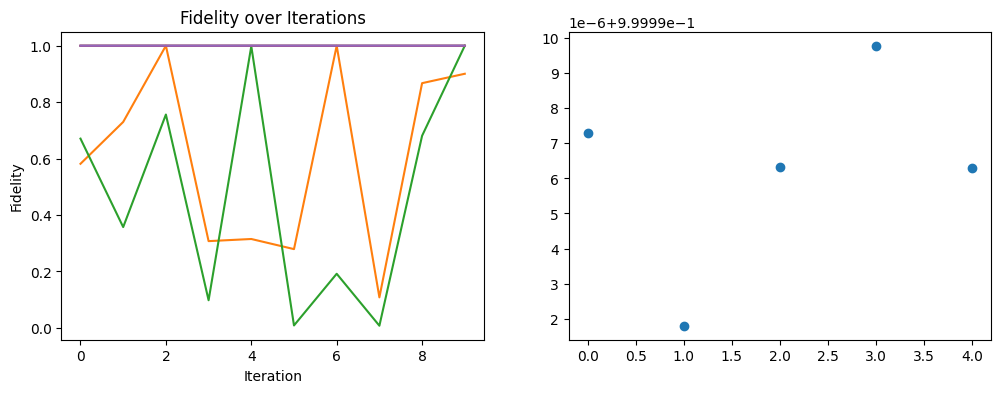

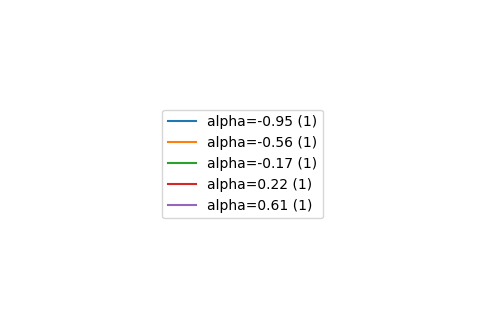

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for fidelities, label in zip(fidelity_lists, fidelity_labels):
    ax1.plot(fidelities, label=label)
    print(f"max fidelity: {label}", max(fidelities))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fidelity")
ax1.set_title("Fidelity over Iterations")

ax2.plot([max(fidelities) for fidelities in fidelity_lists], label=label, marker="o", linestyle='None')

# legend in seperate figure
fig2, ax2 = plt.subplots(1,1, figsize=(6,4))
ax2.legend(*ax1.get_legend_handles_labels(), loc='center')
ax2.axis('off')

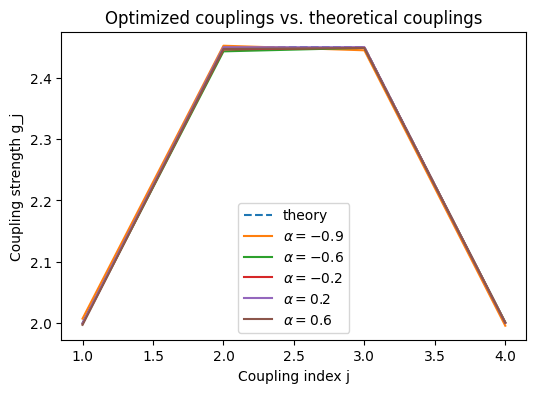

In [ ]:
j_arr = jnp.arange(1, n)

if n <= 3:
    g_theory = jnp.array((n-1)*[1])
else:
    g_theory = jnp.array([jnp.sqrt(j*(n-j)) for j in j_arr])

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(j_arr, g_theory, label="theory", linestyle='dashed')
for k, result in enumerate(best_result_each):
    g_meas = result.optimized_trainable_parameters[0][0]
    ax.plot(j_arr, g_meas, label=f"$\\alpha={alphas[k]:.1f}$", linestyle='solid')
ax.set_xlabel("Coupling index j")
ax.set_ylabel("Coupling strength g_j")
ax.set_title("Optimized couplings vs. theoretical couplings")
ax.legend()

In [ ]:
from library.utils.plot_matrix import plot_matrix

# Check purity of final state each
for k, result in enumerate(best_result_each):
    alpha = alphas[k]
    rho_initial, rho_target = prepare_states(alpha, i, n)

    U_final = transport_unitary(result.optimized_trainable_parameters[0][0])
    print("Transport unitary:", jnp.sum(U_final*U_final.conj().T - jnp.eye(2**n)))
    rho_final = U_final @ rho_initial @ U_final.conj().T

    print(f"alpha = {alpha}")
    print("Initial state purity:", jnp.trace(rho_initial @ rho_initial))
    print("Target state purity:", jnp.trace(rho_target @ rho_target))
    print("Final state purity:", jnp.trace(rho_final @ rho_final))

Transport unitary: (-3.552713678800501e-14+0j)
alpha = -0.95
Initial state purity: (1+0j)
Target state purity: (1+0j)
Final state purity: (0.9999999999999936+0j)
Transport unitary: (-2.1094237467877974e-15+0j)
alpha = -0.5599999999999999
Initial state purity: (1.0000000000000004+0j)
Target state purity: (1.0000000000000004+0j)
Final state purity: (0.9999999999999999+0j)
Transport unitary: (4.063416270128073e-14+0j)
alpha = -0.16999999999999993
Initial state purity: (1.0000000000000002+0j)
Target state purity: (1.0000000000000002+0j)
Final state purity: (1+0j)
Transport unitary: (-6.661338147750939e-16+0j)
alpha = 0.2200000000000002
Initial state purity: (1+0j)
Target state purity: (1+0j)
Final state purity: (1.000000000000005+0j)
Transport unitary: (3.9968028886505635e-15+0j)
alpha = 0.6100000000000001
Initial state purity: (1+0j)
Target state purity: (1+0j)
Final state purity: (0.9999999999999982+0j)


In [ ]:
sum([sigmaz() + sigmaz()])

Array([[ 2.+0.j,  0.+0.j],
       [ 0.+0.j, -2.+0.j]], dtype=complex128)